In [24]:
from math import log2
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize
import torch

import block_formats.experiments as E
import block_formats.quantisation as Q

matplotlib.rcParams.update({"axes.spines.top": False, "axes.spines.right": False, "legend.frameon": False})
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
model = E.RequantisableModel.load("meta-llama/Llama-3.2-1B", DEVICE, torch.bfloat16)

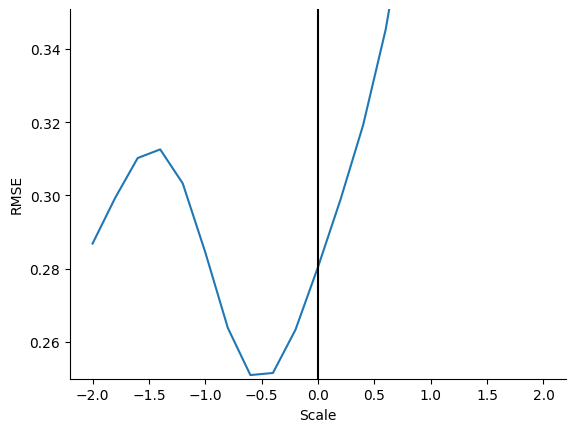

In [9]:
p = torch.distributions.Normal(torch.tensor(0.0, device=DEVICE), torch.tensor(1.0, device=DEVICE)).sample((2**12, 2**12))
# p = torch.distributions.StudentT(torch.tensor(3.0, device=DEVICE)).sample((2**12, 2**12))

element_format = Q.FPFormat(3, 1, "nearest")
# element_format = Q.IntFormat(3)
element_format = Q.crd_t(3, 4)

scaling = "absmax"
scaling = "rms"

base_scale = 1
if scaling == "rms" and element_format._type == "int":
    base_scale = 3**0.5 / element_format.range[1]

pn, ps = Q.block_normalise(p, (1, 64), scaling, element_format.range, Q.BFLOAT16)
def evaluate_rmse(scale: float) -> float:
    return Q.rmse_norm(p, Q.ScaledFormat(element_format, scale, element_format.range).quantise(pn) * ps).item()

log_scales = torch.linspace(log2(base_scale / 4), log2(base_scale * 4), 21)
rmse = [evaluate_rmse(2**logs) for logs in log_scales]

_, ax = plt.subplots()
ax.plot(log_scales, rmse)
ax.axvline(log2(base_scale), color="k")
ax.set_ylim((min(rmse) - 0.001, min(rmse) + 0.1))
ax.set_xlabel("Scale")
ax.set_ylabel("RMSE");

(0.23414749109745026, 0.33514749109745023)

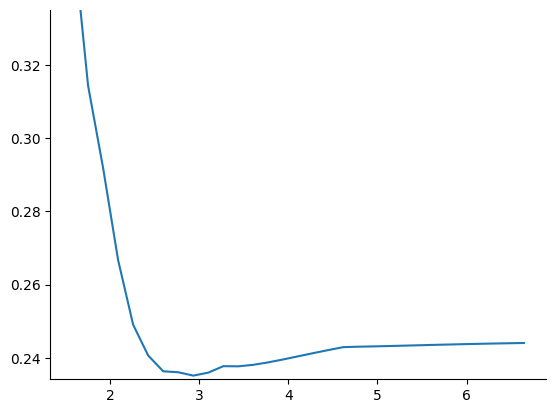

In [ ]:
# p = torch.distributions.Normal(torch.tensor(0.0, device=DEVICE), torch.tensor(1.0, device=DEVICE)).sample((2**12, 2**12))
p = torch.distributions.StudentT(torch.tensor(5.0, device=DEVICE)).sample((2**12, 2**12))
# p = dict(model.model.named_parameters())["model.layers.5.mlp.down_proj.weight"]

scaling = "absmax"
scaling = "rms"

def find_scale(df: float) -> tuple[float, float]:
    element_format = Q.crd_t(3, df=df)
    pn, ps = Q.block_normalise(p, (1, 64), scaling, element_format.range, Q.BFLOAT16)
    def evaluate_rmse(log_scale: float) -> float:
        return Q.rmse_norm(p, Q.ScaledFormat(element_format, 2**log_scale, element_format.range).quantise(pn) * ps).item()

    log_scales = torch.linspace(log2(1 / 4), log2(4), 21).tolist()
    return min([(2**logs, evaluate_rmse(logs)) for logs in log_scales], key=lambda x: x[1])

log_dfs = torch.linspace(log2(3), log2(100), 31).tolist()
rmse = [find_scale(2**log_df)[1] for log_df in log_dfs]

_, ax = plt.subplots()
ax.plot(log_dfs, rmse)

ax.set_ylim((min(rmse) - 0.001, min(rmse) + 0.1))